# 1. Analyzing the Structure of the Network

TODO: description 


In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Building and Visualizing Network

In [2]:
df_nodes = pd.read_csv("data/nodes.dat", delimiter = " ", header = None)
df_nodes.columns = ['nodeID', 'longitude', 'latitude']
df_nodes.head()

,nodeID,longitude,latitude
0,0,-121.904167,41.974556
1,1,-121.902153,41.974766
2,2,-121.896790,41.988075
3,3,-121.889603,41.998032
4,4,-121.886681,42.008739


In [3]:
df_edges = pd.read_csv("data/edges.dat", delimiter = " ", header = None)
df_edges.columns = ['edgeID', 'start node ID', 'end node ID', 'distance']
df_edges.head()

,edgeID,start node ID,end node ID,distance
0,0,0,1,0.002025
1,1,0,6,0.005952
2,2,1,2,0.014350
3,3,2,3,0.012279
4,4,3,4,0.011099


In [4]:
G = nx.Graph()

In [5]:
for i ,row in df_nodes.iterrows():
    G.add_node(int(row["nodeID"]), pos = (row["longitude"], row["latitude"]))

In [6]:
for i, row in df_edges.iterrows():
    G.add_edge(int(row["start node ID"]), int(row["end node ID"])) #

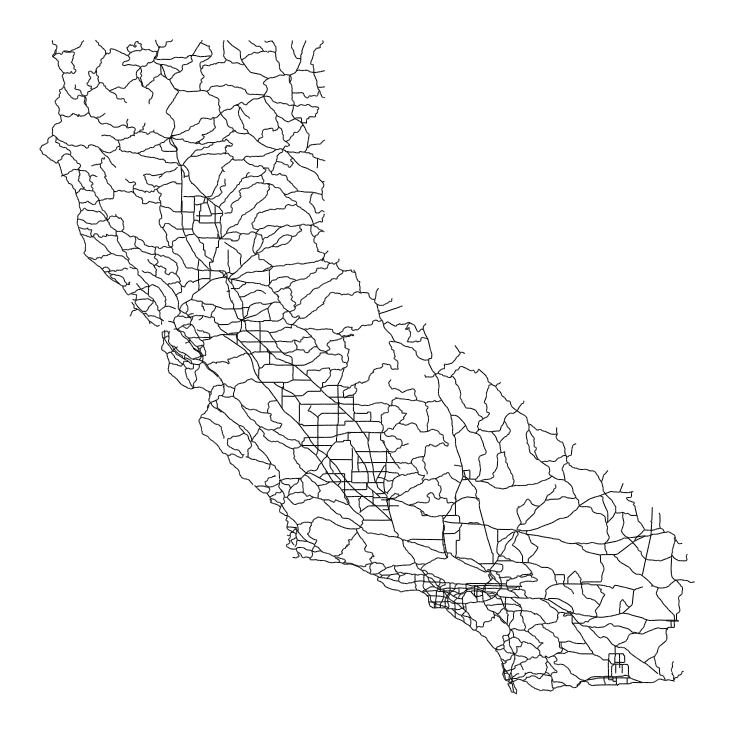

In [7]:
plt.figure(figsize=(10,10))
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, node_size = 0.0)


## Exploring the points of interest

In [8]:
df_places = pd.read_csv("data/places.dat", delimiter = " ", header = None)
df_places.columns = ['name', 'longitude', 'latitude']

In [9]:
df_places.head()

,name,longitude,latitude
0,airport,-114.18639,34.30806
1,airport,-114.43083,34.52750
2,airport,-114.52667,33.86944
3,airport,-114.57528,34.18389
4,airport,-114.60194,34.81944


In [10]:
df_test = df_places.groupby(['name'])
df_test.size()

name
airport     995
arch         20
area        287
arroyo        2
bar         278
           ... 
trail      1187
tunnel      128
valley     7596
well        237
woods       197
Length: 63, dtype: int64

In [11]:
G_places = nx.Graph()

In [12]:
for i ,row in df_places.iterrows():
    G_places.add_node(i, pos = (row["longitude"], row["latitude"]), name = row["name"])

In [13]:
color_map = []
nodes = nx.get_node_attributes(G_places, 'name')
for node in nodes.values():
    if node=='lake':
        color_map.append('blue')
    else: 
        color_map.append('red')

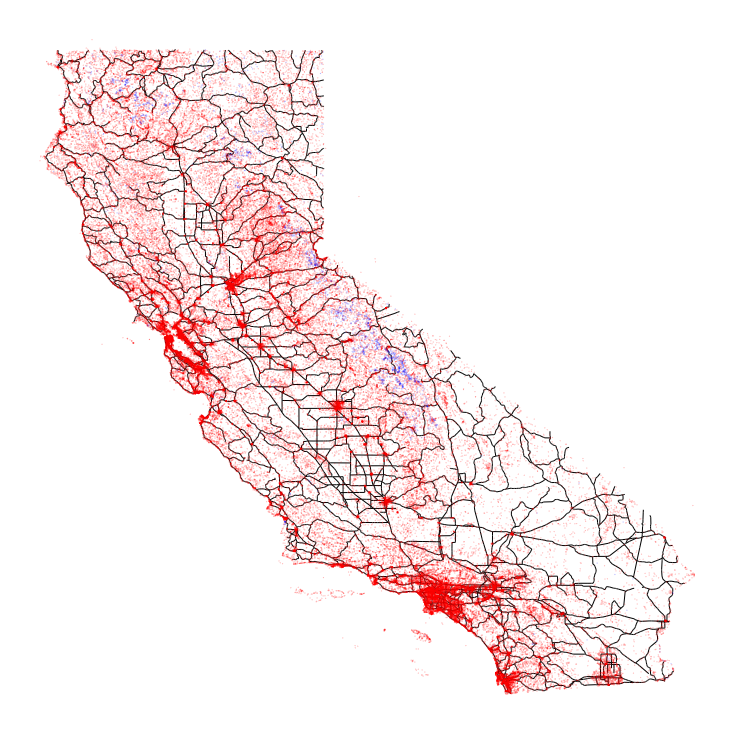

In [14]:
plt.figure(figsize=(10,10))
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, node_size = 0.0)
pos = nx.get_node_attributes(G_places, 'pos')
nx.draw(G_places, pos, node_size = 0.01, node_color=color_map)

## Merge points of interest with road network

In [15]:
'''
For each edge:
Start Node ID, End Node ID, Number of Points on This Edge, Edge Length.
    For each point on this edge:
    Category ID, Distance of This Point to the Start Node of This Edge 
'''

map_file = open("data/mapformat.dat", "r")  
G_merged = nx.Graph()
for line in map_file:
    einfo = line.split()
    num_poi = int(einfo[3])
    pois = []
    if num_poi > 0:
        pois_info = next(map_file).split()
        for i in range(num_poi):
            pois.append({'categoryID': pois_info[i*2], 'distance': float(pois_info[i*2+1])})
    G_merged.add_edge(int(einfo[0]), int(einfo[1]), length=float(einfo[2]), pois=pois)

In [16]:
# add node information
for v in G_merged:
    G_merged.nodes[v]['pos'] =  G.nodes[v]['pos']

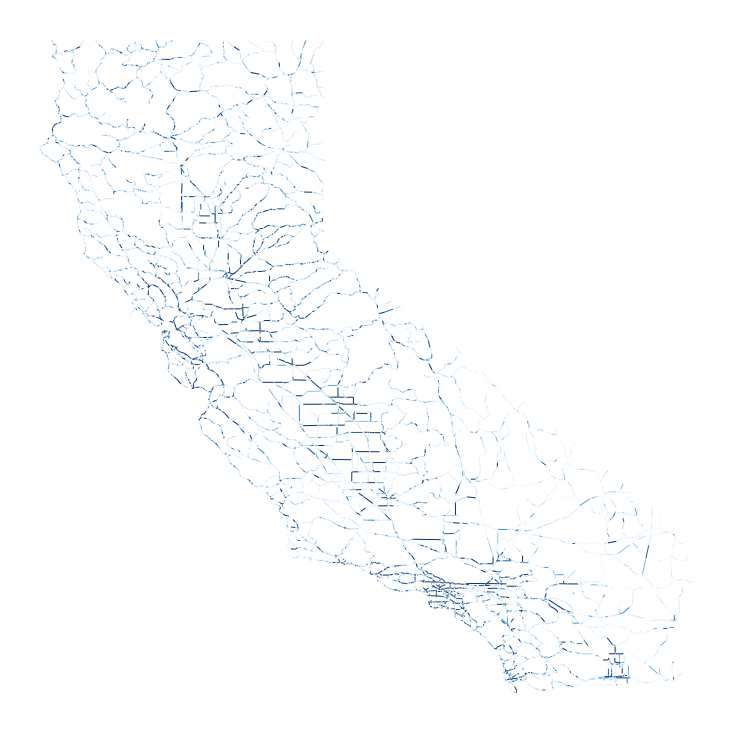

In [17]:
# plot merged graph with intensity of edge based on number of points of interest 
plt.figure(figsize=(10,10))
pos = nx.get_node_attributes(G_merged, 'pos')
def edges_num_pois(g):
    return [len(g[e[0]][e[1]]['pois']) for e in g.edges]
nx.draw(G_merged, pos, node_size=0.0, edge_color=edges_num_pois(G_merged), edge_cmap=plt.cm.Blues, edge_vmin=0, edge_vmax=15)

## Connectivity

In [18]:
# check if all nodes are connected
nx.is_connected(G)

# calculating connectivity for each node takes too long

True

## Degree Distribution

In [19]:
# get distribution from list l
def get_distribution(l):
    l.sort()
    x = []
    y = []
    curr_d = -1
    index = -1
    for d in l:
        if curr_d != d:
            curr_d = d
            index = index + 1
            x.append(d)
            y.append(0)
        y[index] = y[index] + 1
    return (x, y)

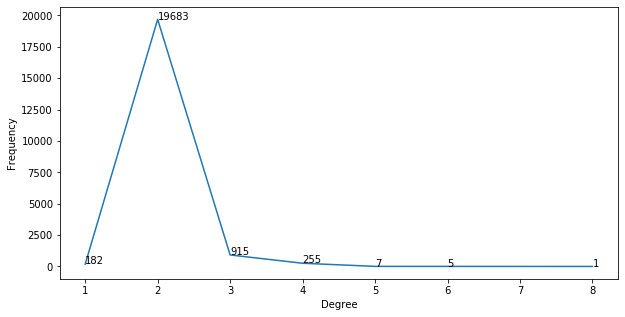

In [20]:
# plot degree distribution
degrees = [G.degree(v) for v in G.nodes]
x, y = get_distribution(degrees)
plt.figure(figsize=(10, 5))
plt.plot(x, y)
plt.xlabel('Degree')
plt.ylabel('Frequency')
for i,j in zip(x,y):
    plt.annotate(str(j),xy=(i,j))

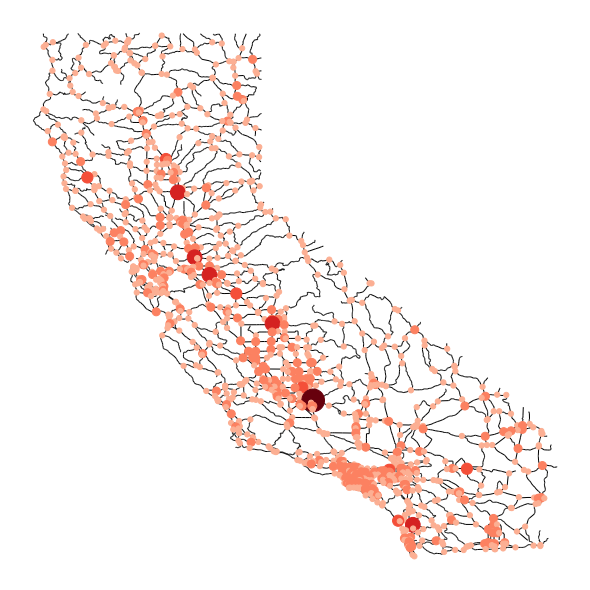

In [21]:
# visualize node degrees (only nodes with deg > 2)
plt.figure(figsize=(8,8))
pos = nx.get_node_attributes(G, 'pos')
degrees = [G.degree(v) for v in G.nodes]
sizes = [d**3 if d > 2 else 0.0 for d in degrees]
nx.draw(G, pos, node_size=sizes, node_color=degrees, cmap=plt.cm.Reds)

## Clustering Coefficient

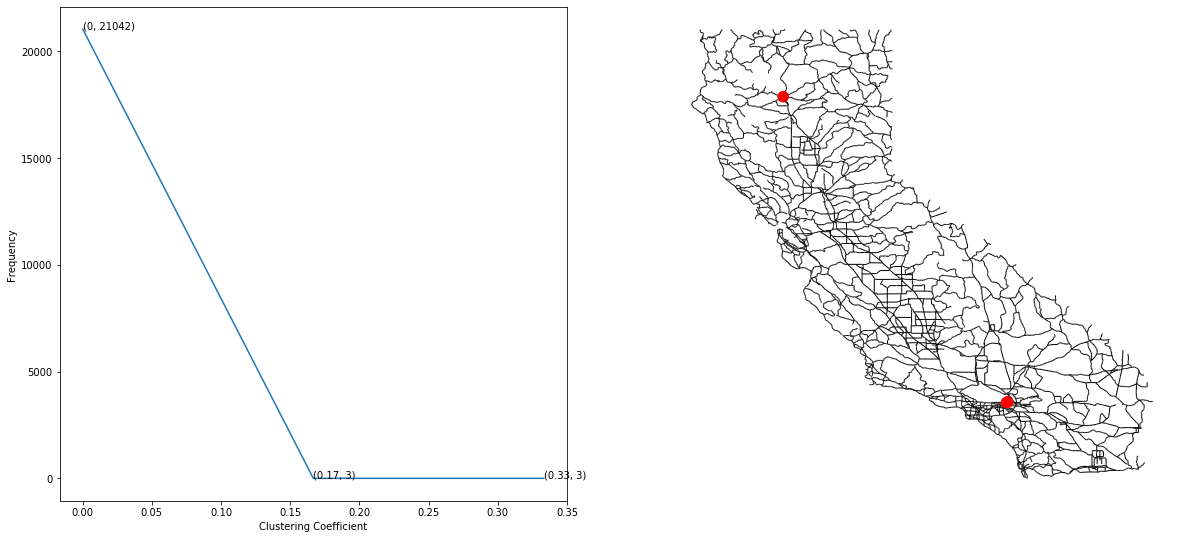

In [22]:
# local clustering coefficients -> distribution
clustering = nx.clustering(G)
x, y = get_distribution(list(clustering.values()))

plt.figure(figsize=(20, 20))
plt.subplot(223)
plt.plot(x, y)
plt.xlabel('Clustering Coefficient')
plt.ylabel('Frequency')
for i,j in zip(x,y):
    plt.annotate(str((round(i, 2), j)),xy=(i,j))
    
plt.subplot(224)
nx.draw(G, pos, node_size=[100 if c > 0 else 0.0 for c in clustering.values()], node_color='r')

In [23]:
# average global clustering coefficient
avg_clustering = nx.average_clustering(G)
print("The average global clustering coefficient is ca. %.6f." % avg_clustering)

The average global clustering coefficient is ca. 0.000071.


## Centrality Measures

In [24]:
# degree centrality: already did this one above
deg_centr = nx.degree_centrality(G_merged) 
deg_list = list(deg_centr.values())

# betweenness centrality: (relative) number of shortest paths that pass through it
betw_centr = nx.betweenness_centrality(G_merged, weight='length', k=20) # approximate from 20 nodes each
betw_list = list(betw_centr.values())

# eigenvector centrality == pagerank
eig_centrality = nx.eigenvector_centrality(G_merged, weight='length')
eig_list = list(eig_centrality.values())

# katz centrality
katz_centrality = nx.katz_centrality(G_merged, weight='length')
katz_list = list(katz_centrality.values())

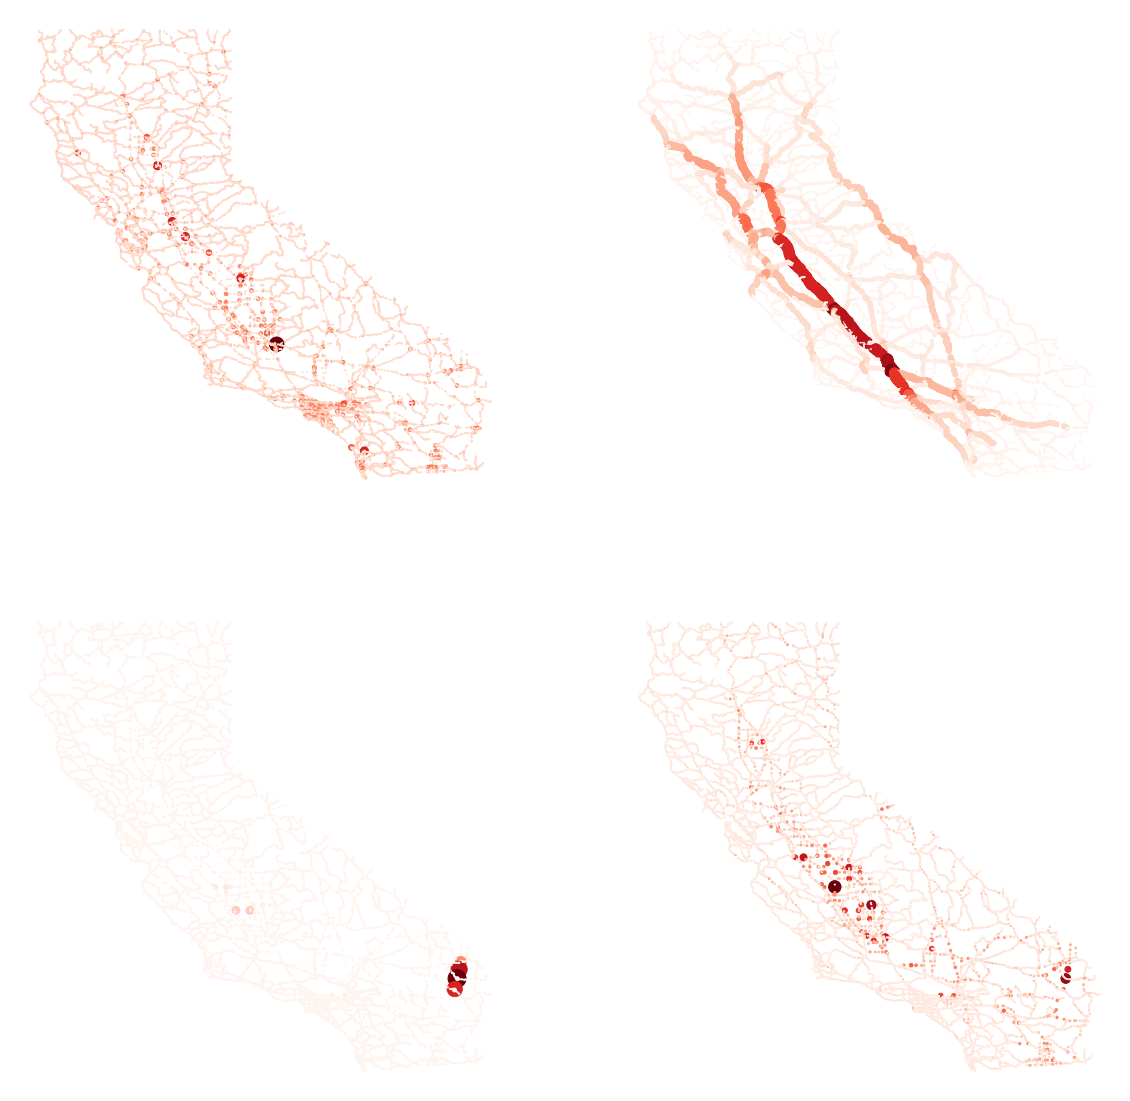

In [25]:
pos = nx.get_node_attributes(G_merged, 'pos')

plt.figure(figsize=(20,20))

plt.subplot(221)
nx.draw(G_merged, pos, edgelist=[], node_size=[(v*10000)**4 for v in deg_list], node_color=deg_list, cmap=plt.cm.Reds)

plt.subplot(222)
nx.draw(G_merged, pos, edgelist=[], node_size=[(v*500) for v in betw_list], node_color=betw_list, cmap=plt.cm.Reds)

plt.subplot(223)
nx.draw(G_merged, pos, edgelist=[], node_size=[1+(v*500) for v in eig_list], node_color=eig_list, cmap=plt.cm.Reds)

plt.subplot(224)
nx.draw(G_merged, pos, edgelist=[], node_size=[(v*145)**110 for v in katz_list], node_color=katz_list, cmap=plt.cm.Reds)

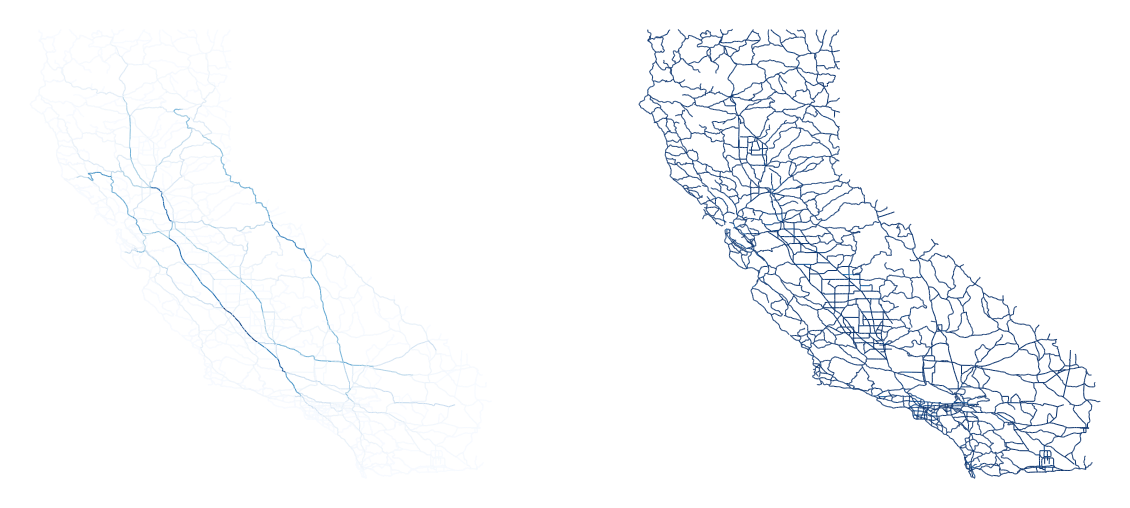

In [26]:
# edge betweenness centrality
edge_betw_centr = nx.edge_betweenness_centrality(G_merged, weight='length', k=20) 
edge_betw_list = list(edge_betw_centr.values())

num_pois =  edges_num_pois(G_merged)
test_measure = [edge_betw_list[i] - (num_pois[i]/1000.0) for i in range(len(num_pois))]
#print(get_distribution(test_measure))

plt.figure(figsize=(20,20))
plt.subplot(221)
nx.draw(G_merged, pos, node_size=0.0, edge_color=edge_betw_list, edge_cmap=plt.cm.Blues)

plt.subplot(222)
nx.draw(G_merged, pos, node_size=0.0, edge_color=test_measure, edge_cmap=plt.cm.Blues)

# 2. Communities

TODO: description

In [27]:
from networkx.algorithms import community
import itertools
import operator

def mvl(g):
    centr = nx.edge_betweenness_centrality(g, weight='length', k=20) # approximate betweeness with 20 nodes
    num_pois = edges_num_pois(g)
    for i, k in enumerate(centr.keys()):
        centr[k] = centr[k] - (num_pois[i]/100.0)
    return max(centr.items(), key=operator.itemgetter(1))[0]
    
com_gen = community.girvan_newman(G_merged, most_valuable_edge=mvl)

In [28]:
k = 0
while k < 58:
    communities = next(com_gen)
    k = len(communities)

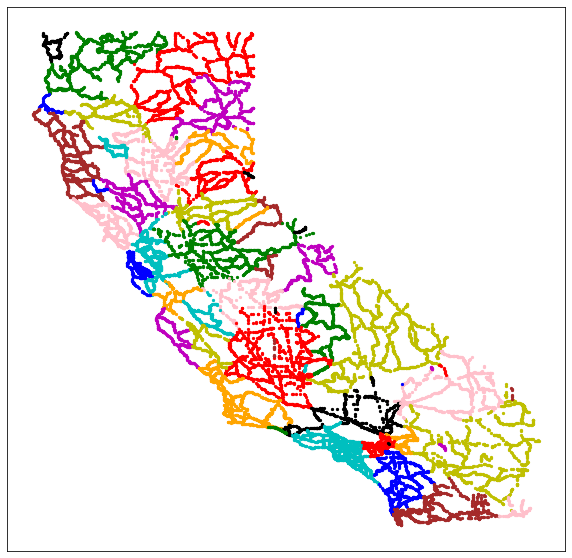

In [29]:
colorlist = ['g', 'r', 'k', 'm', 'b', 'y', 'brown', 'pink', 'orange', 'c']

plt.figure(figsize=(10,10))
for i in range(58):
    nx.draw_networkx_nodes(G_merged, nx.get_node_attributes(G_merged, 'pos'), nodelist = communities[i], node_color=colorlist[i%10], node_size = 5)

(-0.5, 696.5, 769.5, -0.5)

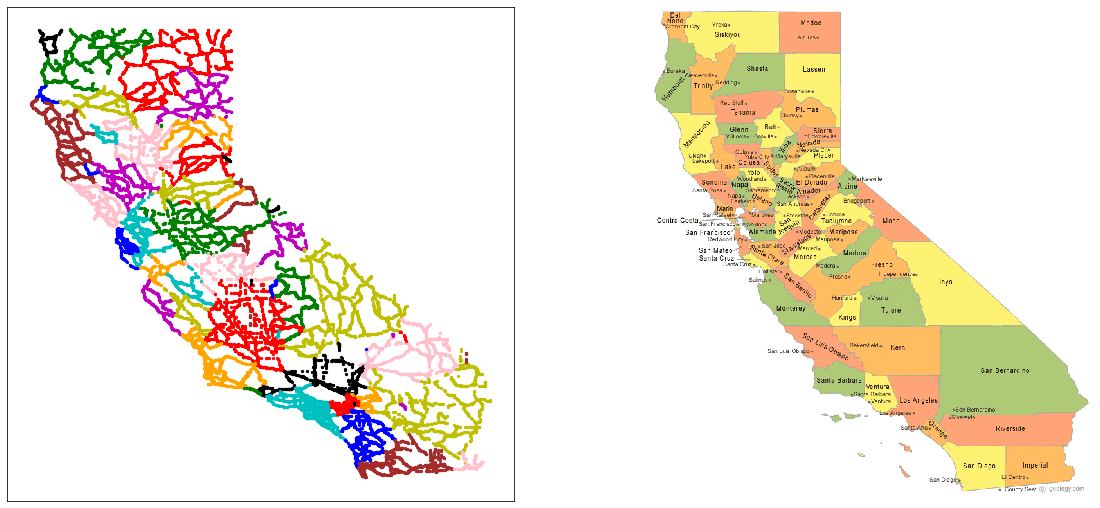

In [30]:
import matplotlib.image as mpimg

plt.figure(figsize=(20,20))
plt.subplot(221)
for i in range(58):
    nx.draw_networkx_nodes(G_merged, nx.get_node_attributes(G_merged, 'pos'), nodelist = communities[i], node_color=colorlist[i%10], node_size = 5)
plt.subplot(222)
plt.imshow(mpimg.imread('data/counties.png'))
plt.axis('off')

In [31]:
# real cities:
df_cities = pd.read_csv("data/cities.csv", delimiter = ";",)
df_cities.head()

,city_ascii,lng,lat,population
0,El Dorado Hills,-121.0490,38.6750,45104.0
1,Lemon Cove,-119.0312,36.3790,232.0
2,Dillon Beach,-122.9560,38.2436,156.0
3,Patterson Tract,-119.2956,36.3795,2320.0
4,Redcrest,-123.9474,40.3987,36.0


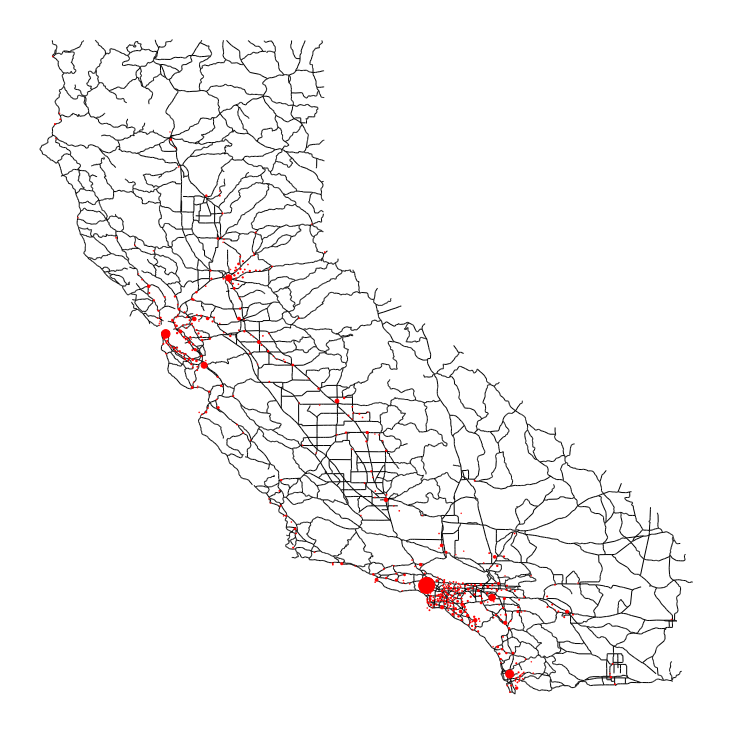

In [32]:
G_cities = nx.Graph()
for i ,row in df_cities.iterrows():
    size = int(row["population"])
    #if size > 400000:
    G_cities.add_node(i, name = row["city_ascii"], pos = (float(row["lng"]), float(row["lat"])), size = size)
    
plt.figure(figsize=(10,10))
nx.draw(G_merged, nx.get_node_attributes(G_merged, 'pos'), node_size=0.0)
sizes = [s/50000 if s > 10000 else 0.0 for s in nx.get_node_attributes(G_cities, 'size').values()]
nx.draw(G_cities, nx.get_node_attributes(G_cities, 'pos'), node_size=sizes, node_color='r')

# 3. Predictions

TODO: description

## Link Prediciton

In [33]:
import random
import math

def filter_nodes_by_pos(g, pos_list, delta):
    # find borders of community
    x_max = -math.inf
    y_max = -math.inf
    x_min = math.inf
    y_min = math.inf
    for x,y in pos_list:
        if x > x_max:
            x_max = x
        if x < x_min:
            x_min = x
        if y > y_max:
            y_max = y
        if y < y_min:
            y_min = y
            
    graph = g.copy()
    for n in g.nodes:
        x,y = graph.nodes[n]['pos']
        if x > x_max-delta or x < x_min+delta or y > y_max-delta or y < y_min+delta:
            graph.remove_node(n)
    return graph
    
# choose one community to analyze 
def choose_community(min_size, max_size, delta, i=0):
    community = []
    while len(community) < min_size or len(community) > max_size:
        community = communities[i]
        i = (i+1) % 58
    graph = G.subgraph(community)
    pos = nx.get_node_attributes(graph, 'pos')
    pos_list = list(pos.values())
    # make graph with POIs in the community
    places = filter_nodes_by_pos(G_places, pos_list, delta)
    return graph, places

com_graph, com_places = choose_community(300, 500, 0.1)

# split edges into test and training set
test_edges = random.sample(com_graph.edges(), int(0.1 * com_graph.number_of_edges()))
train_graph = com_graph.copy()
train_graph.remove_edges_from(test_edges)

print("Size of training set: ", train_graph.number_of_edges())
print("Size of test set: ", len(test_edges))

Size of training set:  338
Size of test set:  37


In [34]:
def evaluate_prediction(prediction):
    max_score = max(prediction, key=lambda p: p[2])[2]
    score = 0.0
    for u, v, s in prediction:
        if (u, v) in test_edges:
            score = score - (1.0 - s/max_score)
        else:
            score = score - s/max_score
    return score

jaccard = list(nx.jaccard_coefficient(train_graph))
print("Score for Jaccard: ", evaluate_prediction(jaccard))

adamic = list(nx.adamic_adar_index(train_graph))
print("Score for Adamic: ", evaluate_prediction(adamic))

pref_att = list(nx.preferential_attachment(train_graph))
print("Score for Preferential Attachment: ", evaluate_prediction(pref_att))

# -> already implemented methods have bad results

Score for Jaccard:  -155.85000000000005
Score for Adamic:  -341.92789260714403
Score for Preferential Attachment:  -14188.8125


In [35]:
def filter_poi(g, attribute, values):
    new_g = g.copy()
    for n in g.nodes:
        x,y = g.nodes[n]['pos']
        if (not g.nodes[n][attribute] in values) or math.isnan(x) or math.isnan(y):
            new_g.remove_node(n)
    return new_g

airports = filter_poi(com_places, 'name', ['airport'])
len(airports.nodes)

17

In [ ]:
N = train_graph.number_of_nodes()
num_features = 2

def distance(x1, y1, x2, y2):
    return np.sqrt(np.square(x1 - x2) + np.square(y1 - y2))

# build feature vector for an edge
def edge_features(g, edge):
    u, v = edge
    features = []
    
    # distance 
    x1, y1 = g.nodes[u]['pos']
    x2, y2 = g.nodes[v]['pos']
    dist = distance(x1, y1, x2, y2)
    features.append(dist)
    
    # num airports between nodes
    num = 0
    for n in airports.nodes:
        x, y = airports.nodes[n]['pos']
        if abs(distance(x1, y1, x, y) + distance(x2, y2, x, y) - dist) < 0.001:
            num = num + 1
    features.append(num)
    return features

# features and labels
X = []
y = []
for u in train_graph.nodes:
    for v in train_graph.nodes:
        if u != v:
            X.append(edge_features(train_graph, (u, v)))
            if (u, v) in train_graph.edges:
                y.append(1)
            else:
                y.append(0)

test = [] 
expected_y = []
for u, _ in test_edges:
    for _, v in test_edges:
        if u != v:
            test.append(edge_features(train_graph, (u, v)))
            if (u, v) in test_edges:
                expected_y.append(1)
            else:
                expected_y.append(0)

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda = QuadraticDiscriminantAnalysis()
predicted_y = qda.fit(X, y).predict(test)

def num_misclass(predicted, expected):
    misclass = 0
    false_pos = 0
    for i in range(len(predicted)):
        if predicted[i] != expected[i]:
            misclass = misclass + 1
            if predicted[i]  == 1:
                false_pos = false_pos + 1
    return misclass, false_pos, misclass - false_pos

m, fp, fn = num_misclass(predicted_y, expected_y)
print("misclassifications: ", m, "/", len(predicted_y), " (", 100 - m*100/len(predicted_y), "% accuracy)")
print("\t\t    ", fp, "/", len(predicted_y)-len(test_edges)," false pos., ", fn, "/", len(test_edges)," false neg.")

## Classify Points of Interest

In [ ]:
com_graph, com_places = choose_community(500, 10000, 0, 35)
com_graph = filter_nodes_by_pos(G, list(nx.get_node_attributes(com_places, 'pos').values()), 0)

# classify between lake, airport and church
categories = {3: 'lake', 2: 'airport', 1: 'church'}
class_graph = filter_poi(com_places, 'name', categories.values())

color_map = []
nodes = nx.get_node_attributes(class_graph, 'name')
for node in nodes.values():
    if node == 'lake':
        color_map.append('blue')
    elif node == 'airport':
        color_map.append('red')
    else:
        color_map.append('yellow')

plt.figure(figsize=(10,10))
nx.draw(com_graph, nx.get_node_attributes(com_graph, 'pos'), node_size = 0.0)
nx.draw(class_graph, nx.get_node_attributes(class_graph, 'pos'), node_size = 20, node_color=color_map)

In [ ]:
# split edges into test and training set
test_nodes = random.sample(class_graph.nodes(), int(0.25 * class_graph.number_of_nodes()))
train_graph = class_graph.copy()
train_graph.remove_nodes_from(test_nodes)

print("Size of training set: ", train_graph.number_of_nodes())
print("Size of test set: ", len(test_nodes))

In [ ]:
# build feature vector for a poi node
def poi_features(g_train, g, n):
    features = []
    x, y = g.nodes[n]['pos']
    cat = g.nodes[n]['name']
    
    # amount of other pois in a close distance 
    num = 0
    for u in g.nodes:
        if u != n:
            x2, y2 = g.nodes[u]['pos']
            if distance(x, y, x2, y2) < 0.1:
                num = num + 1
    features.append(num)
    
    # amount of other poi of the same class in a close distance
    num = 0
    for u in g_train.nodes: # use g_train because category of test nodes not known
        if u != n and g_train.nodes[u]['name'] == cat:
            x2, y2 = g_train.nodes[u]['pos']
            if distance(x, y, x2, y2) < 0.1:
                num = num + 1
    features.append(num)
    
    # distance to nearest road node
    min_dist = math.inf
    for u in com_graph.nodes:
        x2, y2 = com_graph.nodes[u]['pos']
        dist = distance(x, y, x2, y2)
        if dist < min_dist:
            min_dist = dist
    if min_dist == math.inf:
        print(n, x, y, g.nodes[n]['name'], n in test_nodes)
    features.append(min_dist)
    
    # position
    features.append(x)
    features.append(y)
    
    return features

# features and labels
X = []
y = []
for n in train_graph.nodes:
    X.append(poi_features(train_graph, class_graph, n))
    if train_graph.nodes[n]['name'] == 'lake':
        y.append(3)
    elif train_graph.nodes[n]['name'] == 'airport':
        y.append(2)
    else:
        y.append(1)
        

test = [] 
expected_y = []
for n in test_nodes:
    test.append(poi_features(train_graph, class_graph, n))
    if class_graph.nodes[n]['name'] == 'lake':
        expected_y.append(3)
    elif class_graph.nodes[n]['name'] == 'airport':
        expected_y.append(2)
    else:
        expected_y.append(1)
        
qda = QuadraticDiscriminantAnalysis()
predicted_y = qda.fit(X, y).predict(test)

def num_misclass(predicted, expected):
    misclass = 0
    for i in range(len(predicted)):
        if predicted[i] != expected[i]:
            misclass = misclass + 1
    return misclass

m = num_misclass(predicted_y, expected_y)
print("misclassifications: ", m, " of ", len(predicted_y), " (", 100 - m*100/len(predicted_y), "% accuracy)")

# pagerank

In [ ]:
pageranks = nx.pagerank(G)
import operator
# get top n ranked nodes
n = 100
top = []
sorted_pagerank = sorted(pageranks.items(), key=operator.itemgetter(1),reverse = True)
for i in range(n):
    top.append(sorted_pagerank[i][0])

topGraph = nx.subgraph(G,top)
pos = nx.get_node_attributes(topGraph, 'pos')
node_color = ['red' for v in topGraph]
node_size =  [50 for v in topGraph]

plt.figure(figsize=(10,10))
nx.draw_networkx(topGraph, pos, with_labels = False, node_color=node_color,node_size=node_size )
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, node_size = 0.0)


In [ ]:
top = []
sorted_pagerank = sorted(pageranks.items(), key=operator.itemgetter(1),reverse = True)
for i in range(1000):
    top.append(sorted_pagerank[i][0])

centralityGraph = nx.subgraph(G,top)
pos = nx.get_node_attributes(centralityGraph, 'pos')

#Centrality = nx.betweenness_centrality(centralityGraph)  #betweenness
#Centrality = nx.closeness_centrality(centralityGraph)     #closeness
Centrality = nx.degree_centrality(centralityGraph)       #degree


node_size =  [v * 10000 for v in Centrality.values()] 
plt.figure(figsize=(10,10))
nx.draw_networkx(centralityGraph, pos = pos, with_labels = False, node_size = node_size)

### might be useful later

In [ ]:
nx.density(G)

## Graph degrees

In [ ]:
d = dict(nx.degree(G))

In [ ]:
degrees = sorted(d.items(), key=operator.itemgetter(1),reverse = True)
nodes = []
for item in degrees:
    if(int(item[1]) > 2):
        nodes.append(item[0])

print(len(nodes))
subgraph = nx.subgraph(G, nodes)
pos = nx.get_node_attributes(subgraph, 'pos')
node_color = ['red' for v in subgraph]
node_size =  [10 for v in subgraph]

plt.figure(figsize=(10,10))
nx.draw_networkx(subgraph, pos, with_labels = False, node_color=node_color,node_size=node_size )
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, node_size = 0.0)



### create new graph based on degree values

In [ ]:
paths = nx.all_shortest_paths(G,nodes,nodes)

In [ ]:
newGraph = nx.Graph()

for node in nodes:
    newGraph.add_node(node)

In [ ]:
from itertools import islice

for node in nodes:
    paths = dict(nx.single_source_shortest_path_length(G,node))
    shortestPaths = sorted(paths.items(), key=operator.itemgetter(1),reverse = False)
    shortestPathsToNode = {}

    degreeOfNode = d[node]

    for item in shortestPaths:
        if(int(item[0]) in nodes):
            shortestPathsToNode[int(item[0])] = int(item[1])

    truePaths = {}

    n_items = list(islice(shortestPathsToNode, degreeOfNode+1)) #exclude the node itself
    n_items.pop(0)
    for item in n_items:
        if(newGraph.has_edge(node, item)==False):
            newGraph.add_edge(node, item)



In [ ]:
plt.figure(figsize=(6,6))
pos = nx.get_node_attributes(subgraph, 'pos')
nx.draw(newGraph, pos, node_size=6)

### try communities on the smaller graph

In [ ]:
from networkx.algorithms import community
comp = community.girvan_newman(newGraph)

In [ ]:
k = 2
gn_communities = next(islice(comp, k, None))


In [ ]:
len(gn_communities)

In [ ]:
from matplotlib import cm

gn_dict_communities = {}

for i, c in enumerate(gn_communities):
    print ("Community {}".format(i))
    for node in c:
        gn_dict_communities[node] = i + 1
        
for node in newGraph:
    if node not in gn_dict_communities.keys():
        gn_dict_communities[node] = -1

        
gn_colors = []
for node in newGraph.nodes:
    gn_colors.append(cm.tab20(gn_dict_communities[node]))

plt.figure(figsize=(10,10))
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, node_size = 0.0)
nx.draw_networkx_nodes(newGraph, pos, node_color=gn_colors, node_size = 10)
